In [1]:
import vaex
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import math
import pandas as pd
from datetime import datetime, timedelta, date, time
from shapely import Polygon
import contextily as cx
import h3
import seaborn as sns

In [2]:
df = vaex.open("data/trips/trips_prepared.hdf5")

In [3]:
df.info()

column,type,unit,description,expression
Taxi ID_encoded,int64,,,
Company,str,,,
Company_encoded,int64,,,
ts_start,datetime64[us],,,
ts_end,datetime64[us],,,
start_day,datetime64[us],,,
start_weekday,int32,,,
start_month,int32,,,
Trip Seconds,float64,,,
Trip Miles,float64,,,


## Temporal Demand

In [4]:
df_weekday = df[df.start_weekday.isin([0, 1, 2, 3, 4])]
df_weekend = df[df.start_weekday.isin([5, 6])]

In [5]:
# Calculate the average trips per hour for weekdays and weekends
average_trips_weekday = df_weekday.groupby(df_weekday.start_1_hour).agg({'Trip Total': 'mean'})['Trip Total'].values
average_trips_weekend = df_weekend.groupby(df_weekend.start_1_hour).agg({'Trip Total': 'mean'})['Trip Total'].values


In [6]:
angles = np.linspace(0, 2 * np.pi, num=24, endpoint=False)

#vaex to numpy array
average_trips_weekday = average_trips_weekday
average_trips_weekend = average_trips_weekend


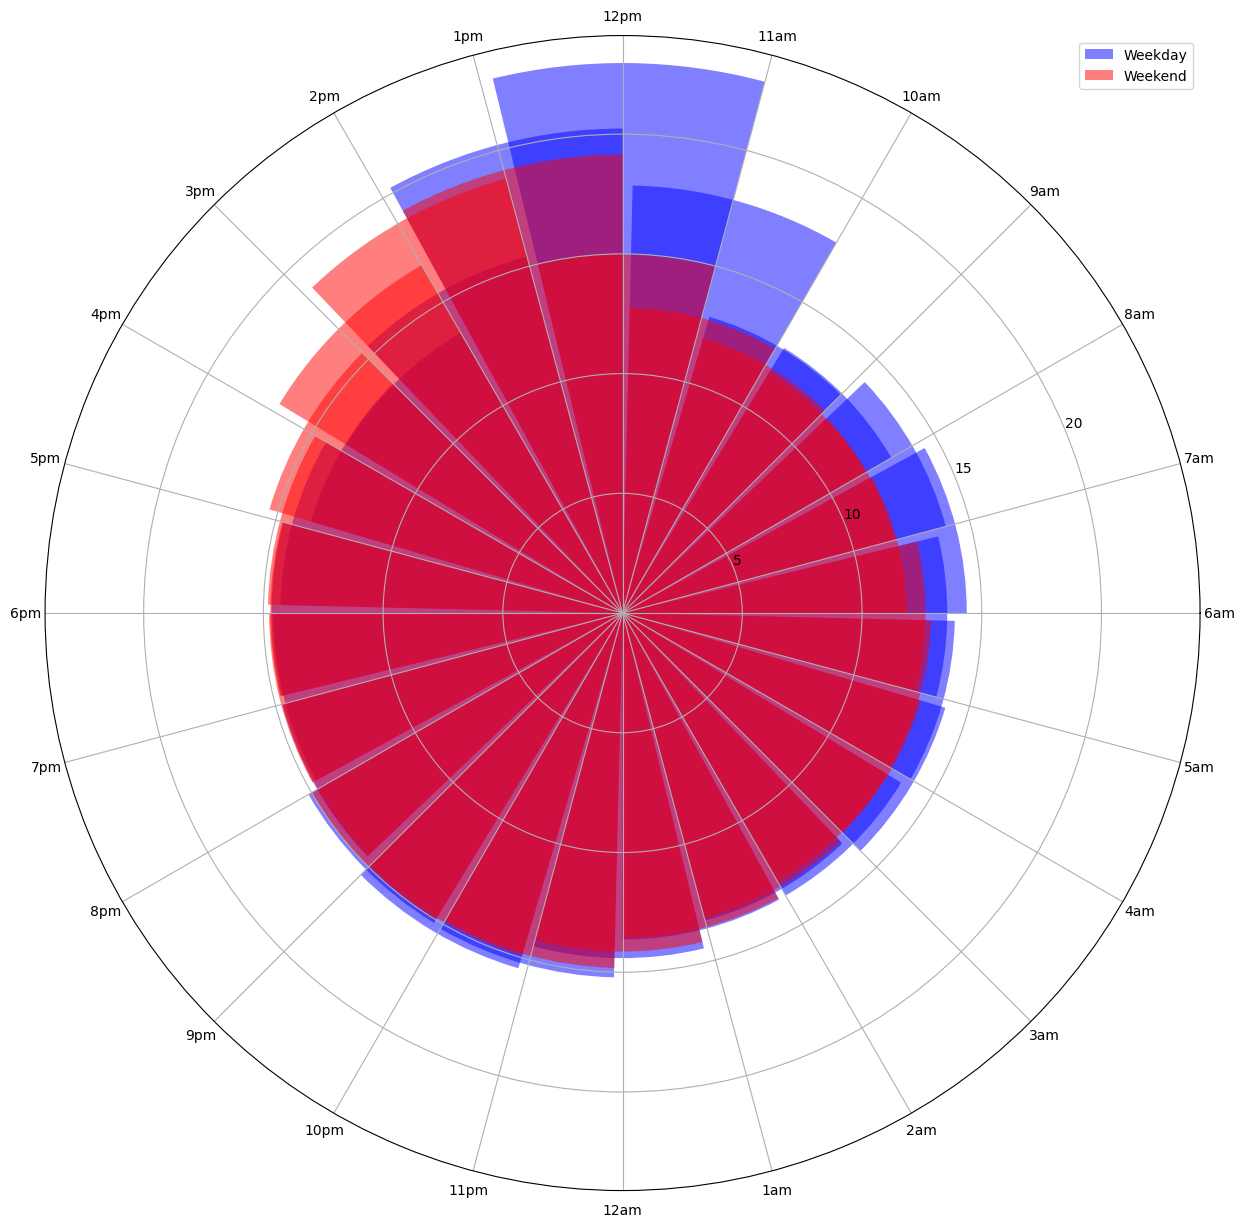

In [7]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, polar=True)

#shifted_angles = np.roll(angles, -6)

# Plot average trips for weekdays in blue
ax.bar(angles, average_trips_weekday, width=0.5, align='edge', label='Weekday', color='blue', alpha=0.5)


# Plot average trips for weekends in red
ax.bar(angles, average_trips_weekend, width=0.5, align='edge', label='Weekend', color='red', alpha=0.5)

ax.set_xticks(angles)
ax.set_xticklabels(['6am', '7am', '8am', '9am', '10am', '11am', '12pm', '1pm',
                    '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm',
                    '10pm', '11pm', '12am', '1am', '2am', '3am', '4am', '5am'])

ax.legend()
plt.show()


In [8]:
#print(angles.shape)
#print(average_trips_weekday.shape)
#print(average_trips_weekend.shape)
import pandas as pd
df_pandas = df.to_pandas_df()

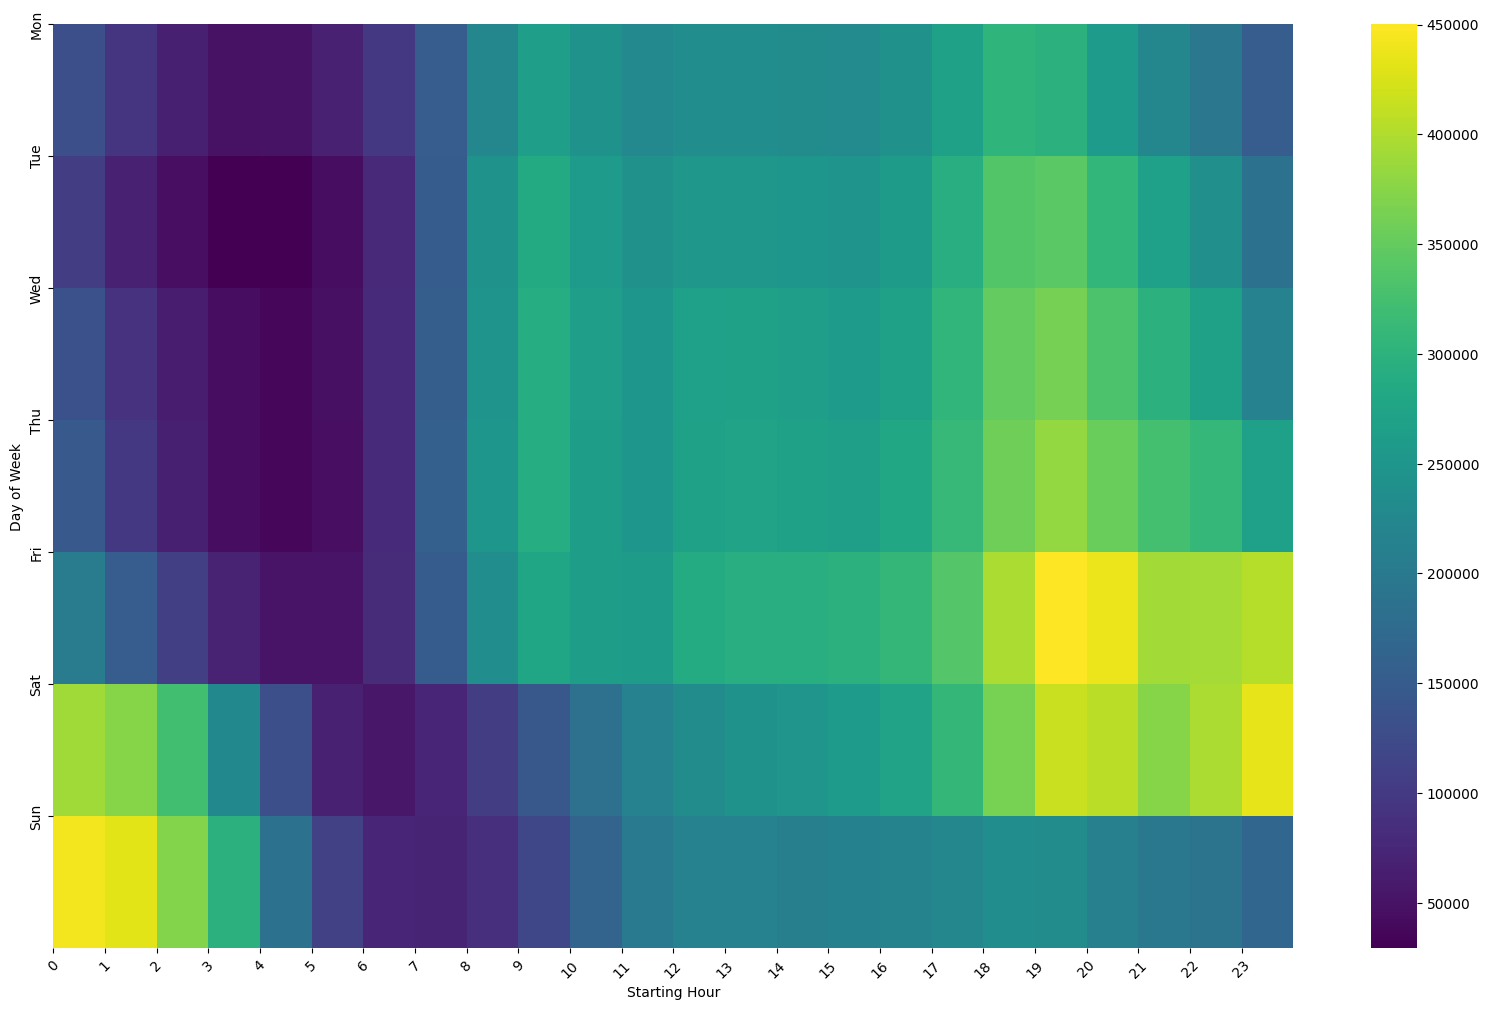

In [9]:
extract_1 = ['start_weekday', 'start_1_hour']
heatmap_df = df[extract_1]
pd_heatmap = heatmap_df.to_pandas_df()

# Calculate the count of trips for each combination of start_weekday and start_1_hour
heatmap_data = pd_heatmap.groupby(['start_weekday', 'start_1_hour']).size().unstack()

# Create a figure and axes for the heatmap
fig, ax = plt.subplots(figsize=(20, 12))

# Create the heatmap using seaborn 
sns.heatmap(heatmap_data, cmap='viridis', ax=ax)

# Set the labels for the x and y axes
ax.set_xlabel('Starting Hour')
ax.set_ylabel('Day of Week')

# Set the tick locations and labels for the x and y axes
ax.set_xticks(np.arange(24))
ax.set_xticklabels(np.arange(24))
ax.set_yticks(np.arange(7))
ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Show the heatmap
plt.show()


The chart contrasts the volume of initial trips across various starting hours and days of the week. It's evident that on weekdays, the majority of trips occur towards the later hours of the day, typically between 5 PM and 8 PM. Additionally, there's a notable surge in trips around 9 AM on weekdays. When coupled with the concentration of trips towards the day's end, this pattern suggests a likelihood of these trips being business-related, possibly involving commuting to and from the office.

During the weekends, commencing from Friday evening, the predominant time for trips is between 6 PM and 3 AM, indicating recreational outings. This interpretation is reinforced by the observation that Sunday evenings experience fewer rides compared to Fridays and Saturdays, likely due to people needing to prepare for work on Monday mornings. This distinction underscores the weekday commuting trend at 9 AM, which is absent during weekends.

In [10]:
# Calculate average trip distance
average_distance = df['Trip Miles'].mean().item()

# Calculate minimum trip distance
min_distance = df['Trip Miles'].min().item()

# Calculate maximum trip distance
max_distance = df['Trip Miles'].max().item()

print("Average Trip Distance:", average_distance)
print("Minimum Trip Distance:", min_distance)
print("Maximum Trip Distance:", max_distance)

# Calculate average trip duration
average_duration = df['Trip Seconds'].mean().item()

# Calculate minimum trip duration
min_duration = df['Trip Seconds'].min().item()

# Calculate maximum trip duration
max_duration = df['Trip Seconds'].max().item()

print("Average Trip Duration:", average_duration, "seconds")
print("Minimum Trip Duration:", min_duration, "seconds")
print("Maximum Trip Duration:", max_duration, "seconds")


Average Trip Distance: 2.8133396897292244
Minimum Trip Distance: 0.0
Maximum Trip Distance: 1530.4
Average Trip Duration: 738.3478666231151 seconds
Minimum Trip Duration: 0.0 seconds
Maximum Trip Duration: 86340.0 seconds


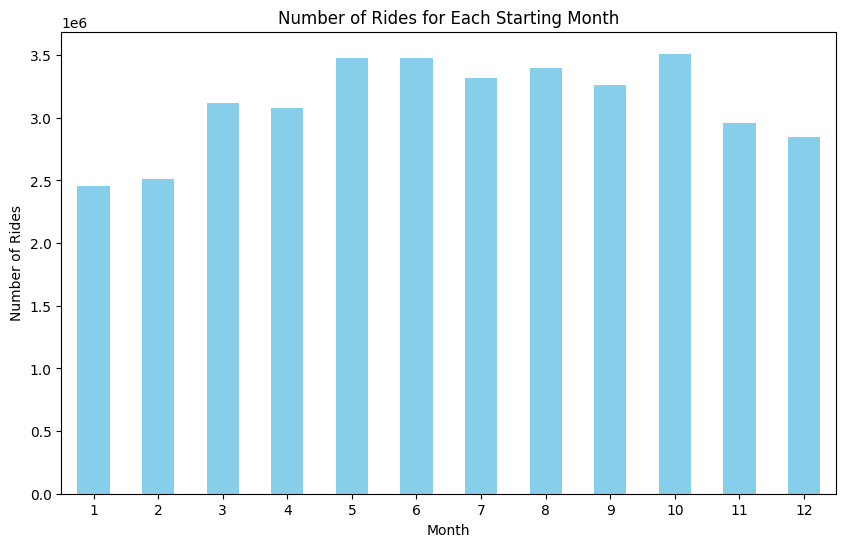

Count of Rides per Month:
start_month
1     2458586
2     2509506
3     3118627
4     3075755
5     3478535
6     3474914
7     3314074
8     3395979
9     3257545
10    3510897
11    2956885
12    2844133
Name: count, dtype: int64
Total Sum of Rides: 37395436


In [11]:
extract_plt = ['ts_start', 'start_weekday', 'start_month']

light_df_plt = df[extract_plt]

light_df_pd = light_df_plt.to_pandas_df()

grouped_by_month = light_df_pd.groupby('start_month').size()

# Create a bar plot
plt.figure(figsize=(10, 6))
grouped_by_month.plot(kind='bar', color='skyblue')
plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.title('Number of Rides for Each Starting Month')
plt.xticks(rotation=0)
plt.show()

grouped_by_month = light_df_pd.groupby('start_month')['ts_start'].agg(count='count')

# Print the count of rides and average trips per month
print("Count of Rides per Month:")
print(grouped_by_month['count'])

rides_sum_per_month = light_df_pd.groupby('start_month')['ts_start'].count()

# Calculate the total sum of rides across all months
total_rides_sum = rides_sum_per_month.sum()

# Print the total sum of rides
print("Total Sum of Rides:", total_rides_sum)

The graph unveils that the peak period for trips spans from May to October. Notably, October emerges as the month with the highest number of trips taken. Conversely, the winter months from November to February experience a decrease in trip numbers compared to the rest of the year.

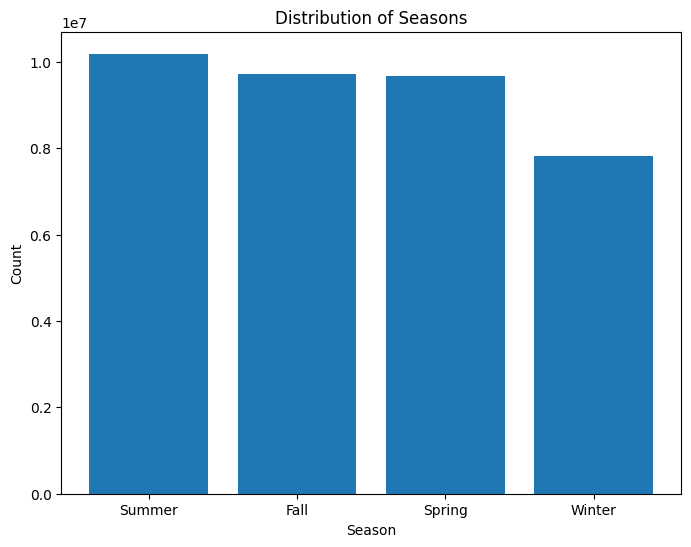

In [12]:
#Assigning a season to each entry
def map_month_to_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'


df['season'] = df.apply(map_month_to_season, arguments=[df['start_month']])

# Plot the distribution of seasons
df_grouped = df.groupby('season', agg={'count': vaex.agg.count()})
df_grouped = df_grouped.sort(by='count', ascending=False)

# Convert vaex DataFrame to a pandas DataFrame for plotting with matplotlib
df_pandas = df_grouped.to_pandas_df()

# Create a bar plot using matplotlib
plt.figure(figsize=(8, 6))
plt.bar(df_pandas['season'], df_pandas['count'])
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Distribution of Seasons')
plt.show()

As depicted in the plot, the highest number of trips occur during the summer season, spanning from June to August. Fall and Spring exhibit nearly equivalent trip counts. Conversely, the winter season witnesses a notably lower number of trips compared to the other seasons, experiencing approximately 20% fewer trips than during the summer season.

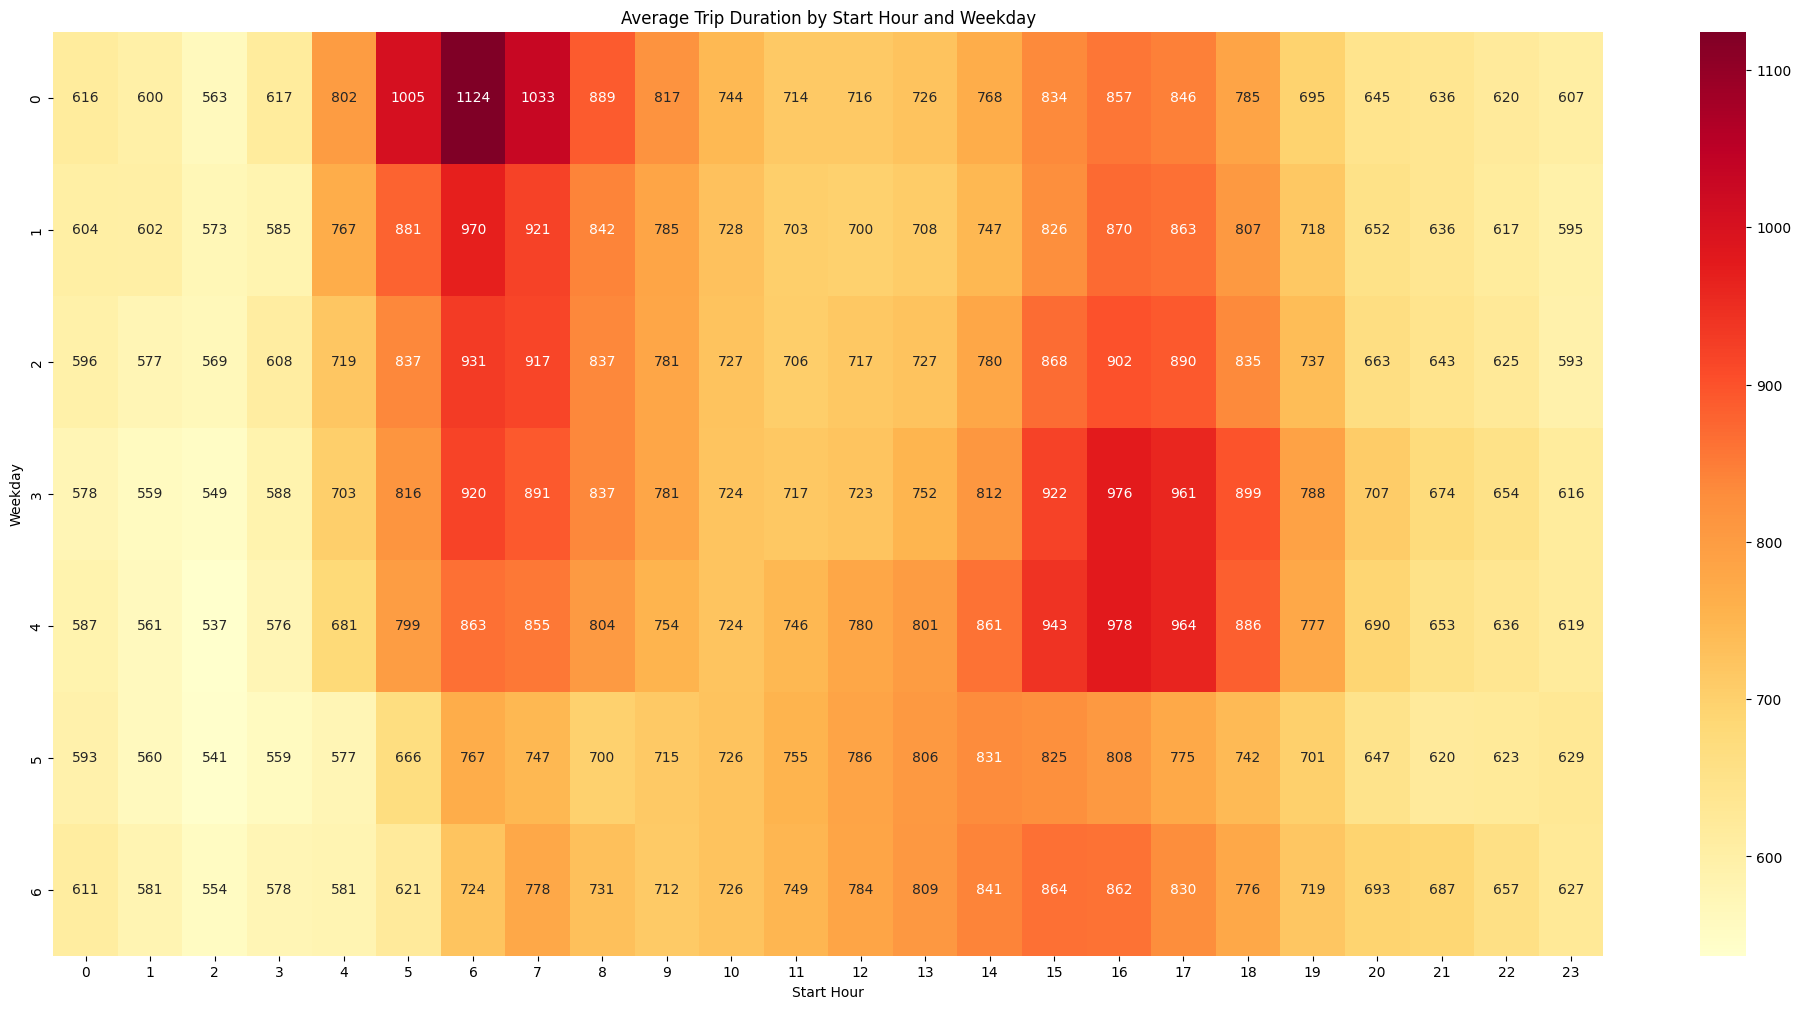

In [13]:
extract_2 = ['Trip Seconds', 'start_weekday', 'start_1_hour']
df_prep_raw = df[extract_2]
df_prep = df_prep_raw.to_pandas_df()

# Create a pivot table to calculate the average trip duration
pivot_table = df_prep.pivot_table(values='Trip Seconds', index='start_weekday', columns='start_1_hour', aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(25, 12))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.0f', cbar=True)
plt.title('Average Trip Duration by Start Hour and Weekday')
plt.xlabel('Start Hour')
plt.ylabel('Weekday')
plt.show()


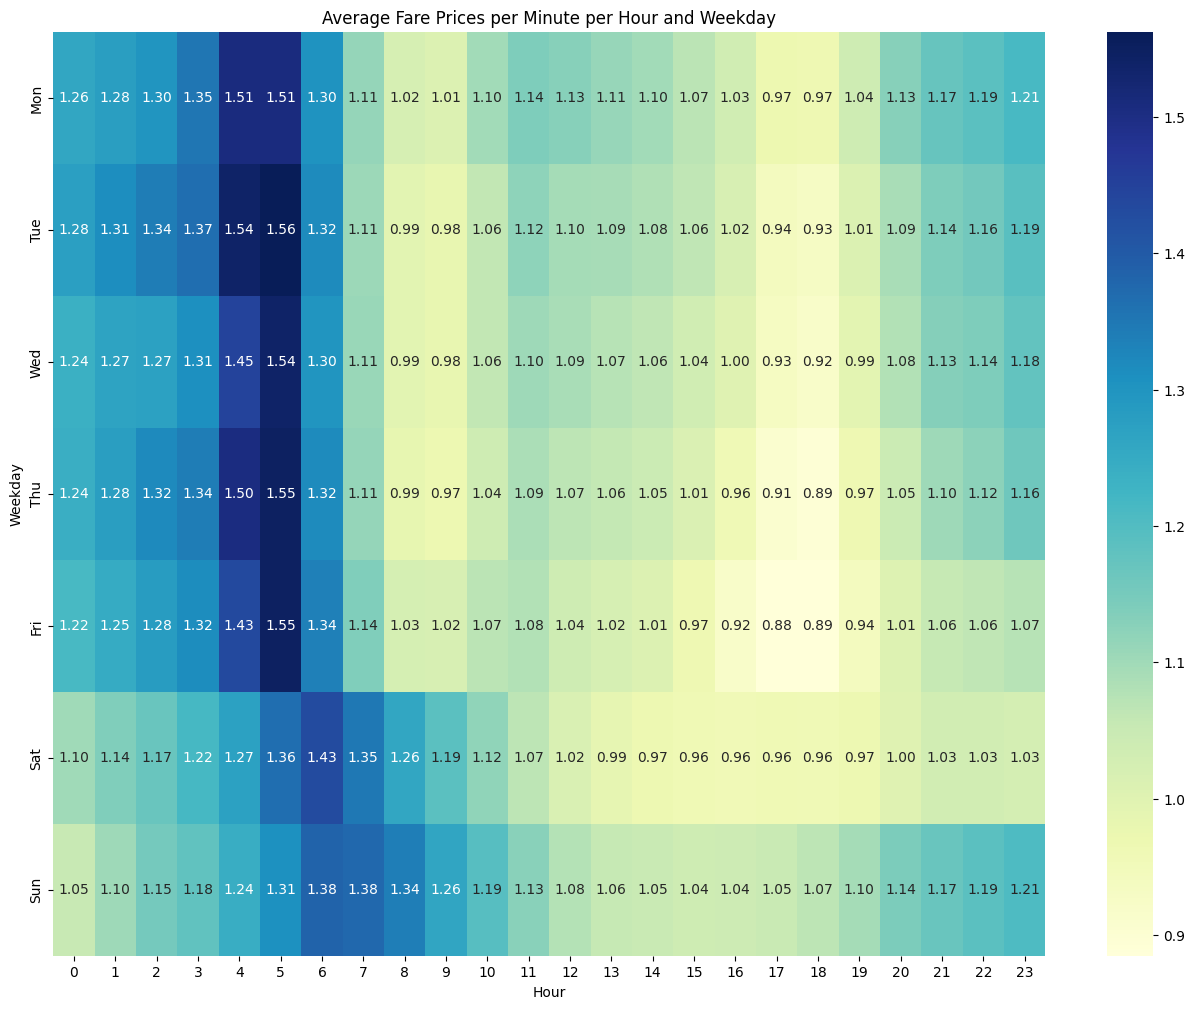

In [14]:
#Creating a fitting DF
extract_3 = ['Trip Seconds', 'Fare', 'start_1_hour', 'start_weekday']
df_fare = df[extract_3]
df_fare_rdy = df_fare.to_pandas_df()

#Creating column Fare per Minute and dropping NaN and INF
df_fare_rdy['Fare per Second'] = df_fare_rdy['Fare'] / df_fare_rdy['Trip Seconds']
df_fare_rdy.replace([np.inf, -np.inf], np.nan, inplace=True)
df_fare_rdy.dropna(inplace=True)
df_fare_rdy['Fare per Minute'] = df_fare_rdy['Fare per Second'] * 60

#Filtering out fares per minute that are over 40 USD as they are overproportional (They might have emerged because of errors in the transformation)
threshold = 40
filtered_df = df_fare_rdy[df_fare_rdy['Fare per Minute'] <= threshold]
pivot2 = filtered_df.pivot_table(values='Fare per Minute', index='start_weekday', columns='start_1_hour', aggfunc='mean')

#Plotting the results
custom_y_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(16, 12))
sns.heatmap(pivot2, cmap='YlGnBu', annot=True, fmt=".2f", yticklabels=custom_y_labels)
plt.title('Average Fare Prices per Minute per Hour and Weekday')
plt.xlabel('Hour')
plt.ylabel('Weekday')
plt.show()


The graph illustrates the average fare per minute prices across different hours of the day and days of the week. Notably, the fare exhibits its highest point on weekdays between 4 and 5 am, as well as on weekends between 5 and 8 am. Conversely, the fare reaches its lowest point on weekdays from 5 to 6 pm.

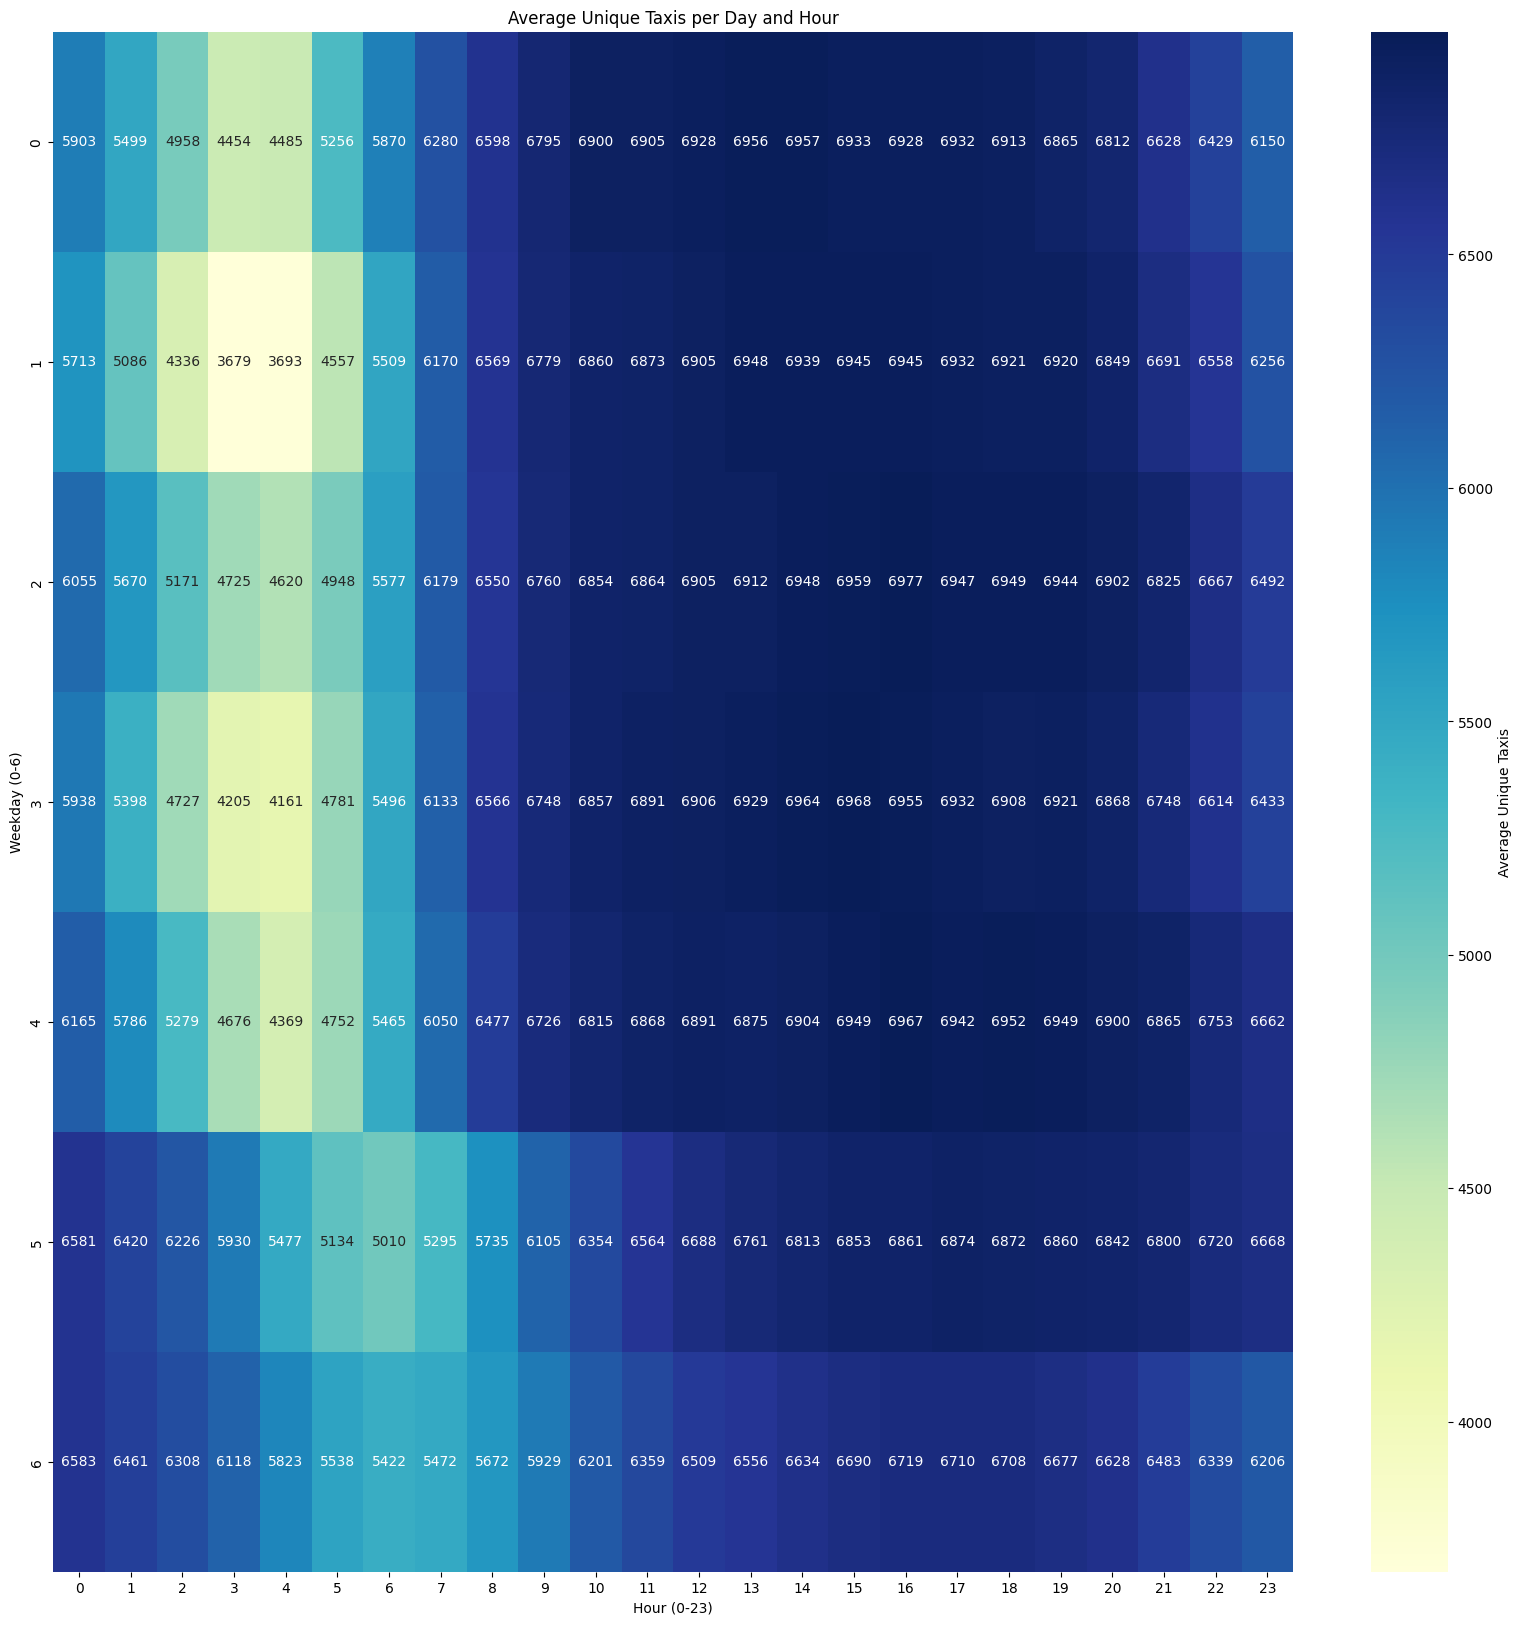

In [15]:
extract_4 = ['start_1_hour', 'start_weekday', 'Taxi ID_encoded']
df_tax = df[extract_4]
df_taxi = df_tax.to_pandas_df()

# Grouping by 'start_1_hour' and 'start_weekday', then calculating the number of unique taxis
grouped = df_taxi.groupby(['start_1_hour', 'start_weekday'])['Taxi ID_encoded'].nunique()

# Reshaping the grouped data to form a pivot table
heatmap_data = grouped.reset_index().pivot('start_weekday', 'start_1_hour', 'Taxi ID_encoded')

# Creating a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.0f', cbar_kws={'label': 'Average Unique Taxis'})
plt.title('Average Unique Taxis per Day and Hour')
plt.xlabel('Hour (0-23)')
plt.ylabel('Weekday (0-6)')
plt.show()



The graph illustrates the average number of different taxis operating during specific hours and weekdays. It is clear that taxi availability is at its lowest on weekdays from 3 am to 6 am, as well as on weekends between 5 am and 7 am. In contrast, the highest taxi availability on weekdays occurs between 2 pm and 7 pm, and on weekends between 3 pm and 6 pm. This visual representation might potentially help to understand the fluctuating fare per minute prices shown in the graph above. Notably, there seems to be a reverse relationship between taxi activity and fare prices, where greater taxi availability corresponds to lower fare prices, and vice versa.

### Import of Spatial and Weather Data

In [16]:
#Hexagons
trips_df_1h_r7 = vaex.open('data/trips/trips_grouped_1h_r7.hdf5')
trips_df_1h_r8 = vaex.open('data/trips/trips_grouped_1h_r8.hdf5')
trips_df_1h_r9 = vaex.open('data/trips/trips_grouped_1h_r9.hdf5')

trips_df_4h_r7 = vaex.open('data/trips/trips_grouped_4h_r7.hdf5')
trips_df_4h_r8 = vaex.open('data/trips/trips_grouped_4h_r8.hdf5')
trips_df_4h_r9 = vaex.open('data/trips/trips_grouped_4h_r9.hdf5')

trips_df_6h_r7 = vaex.open('data/trips/trips_grouped_6h_r7.hdf5')
trips_df_6h_r8 = vaex.open('data/trips/trips_grouped_6h_r8.hdf5')
trips_df_6h_r9 = vaex.open('data/trips/trips_grouped_6h_r9.hdf5')


#Census Tract and Community Area data
trips_df_1h_census = vaex.open('data/trips/trips_grouped_1h_census.hdf5')
trips_df_1h_carea = vaex.open('data/trips/trips_grouped_1h_comArea.hdf5')

trips_df_4h_census = vaex.open('data/trips/trips_grouped_4h_census.hdf5')
trips_df_4h_carea = vaex.open('data/trips/trips_grouped_4h_comArea.hdf5')

trips_df_6h_census = vaex.open('data/trips/trips_grouped_6h_census.hdf5')
trips_df_6h_carea = vaex.open('data/trips/trips_grouped_6h_comArea.hdf5')

df_tracts = gpd.read_file('data/raw/census_tract_geometry.geojson')
df_commarea = gpd.read_file('data/raw/community_area_geometry.geojson')

#Weather
weather_df_1h = pd.read_pickle('data/weather_data_hourly_1.pickle')
weather_df_4h = pd.read_pickle('data/weather_data_hourly_4.pickle')
weather_df_6h = pd.read_pickle('data/weather_data_hourly_6.pickle')

[08/11/23 19:54:48] ERROR    error opening 'data/trips/trips_grouped_1h_r7.hdf5'                    ]8;id=796363;file://c:\Users\mheer\AppData\Local\Programs\Python\Python310\lib\site-packages\vaex\__init__.py\__init__.py]8;;\:]8;id=174414;file://c:\Users\mheer\AppData\Local\Programs\Python\Python310\lib\site-packages\vaex\__init__.py#269\269]8;;\
                             Traceback (most recent call last):                                                    
                               File                                                                                
                             "c:\Users\mheer\AppData\Local\Programs\Python\Python310\lib\site-packa                
                             ges\vaex\__init__.py", line 242, in open                                              
                                 ds = vaex.dataset.open(path, fs_options=fs_options, fs=fs,                        
                             **kwargs)                                                                             
                               File                                                                                
                             "c:\Users\mheer\AppData\Local\Programs\Python\Python310\lib\site-packa                
                             ges\vaex\dataset.py", line 80, in open                                                
                                 if opener.can_open(path, fs_options=fs_options, fs=fs, *args,                     
                             **kwargs):                                                                            
                               File                                                                                
                             "c:\Users\mheer\AppData\Local\Programs\Python\Python310\lib\site-packa                
                             ges\vaex\hdf5\dataset.py", line 167, in can_open                                      
                                 with vaex.file.open(path, fs_options=fs_options, fs=fs) as f:                     
                               File                                                                                
                             "c:\Users\mheer\AppData\Local\Programs\Python\Python310\lib\site-packa                
                             ges\vaex\file\__init__.py", line 320, in open                                         
                                 return normal_open(path, mode)                                                    
                             FileNotFoundError: [Errno 2] No such file or directory:                               
                             'data/trips/trips_grouped_1h_r7.hdf5'                                                 

FileNotFoundError: [Errno 2] No such file or directory: 'data/trips/trips_grouped_1h_r7.hdf5'

### Function Definition: Groupings and Maps

#### Hexagons

In [ ]:
#Method to convert the hexagons to polygons using H3
def convert_hex_to_polygon(hex):
        polygon = None
        if hex:
               polygon = Polygon(h3.h3_to_geo_boundary(hex, geo_json=True))         
        return polygon

In [ ]:
#A function to aggregate the trips for census tract and community area pickup and dropoff to create a geodataframe for visual representation
def create_hex_geodataframe(df, geometry):

    gdf = df.drop_duplicates()

    #Create the geodataframe and specify the geometry column for visual representation
    gdf = gpd.GeoDataFrame(gdf, geometry=geometry, crs="EPSG:4326")

    return gdf

In [ ]:
def process_dataframes(df, hour, resolution, weather_df):
    trip_attributes = [
        'ts_start_{}_hour'.format(hour),
        'start_month',
        'start_weekday',
        'start_{}_hour'.format(hour),
        'pickup_hex_{}'.format(resolution),
        'demand',
        'Trip Seconds',
        'Trip Miles',
        'Fare',
        'Trip Total'
    ]
    
    df = df[trip_attributes].to_pandas_df()
    df_w = df.merge(weather_df, left_on = 'ts_start_{}_hour'.format(hour), right_on = 'datetime', how = 'left')
    df_w = df_w[(df_w['pickup_hex_{}'.format(resolution)].notna()) & (df_w['pickup_hex_{}'.format(resolution)] != 'None')]
    #df_w['geometry'] = df_w['pickup_hex_{}'.format(resolution)].apply(convert_hex_to_polygon)


    return df_w

In [ ]:
#Prepare data for 1 hourly and resolutions 7 - 9
trips_gdf_1h_r7_w = process_dataframes(trips_df_1h_r7, 1, 7, weather_df_1h)
trips_gdf_1h_r8_w = process_dataframes(trips_df_1h_r8, 1, 8, weather_df_1h)
trips_gdf_1h_r9_w = process_dataframes(trips_df_1h_r9, 1, 9, weather_df_1h)

In [ ]:
#Prepare data for 4 hourly and resolutions 7 - 9
trips_gdf_4h_r7_w = process_dataframes(trips_df_4h_r7, 4, 7, weather_df_4h)
trips_gdf_4h_r8_w = process_dataframes(trips_df_4h_r8, 4, 8, weather_df_4h)
trips_gdf_4h_r9_w = process_dataframes(trips_df_4h_r9, 4, 9, weather_df_4h)

In [ ]:
#Prepare data for 6 hourly and resolutions 7 - 9
trips_gdf_6h_r7_w = process_dataframes(trips_df_6h_r7, 6, 7, weather_df_6h)
trips_gdf_6h_r8_w = process_dataframes(trips_df_6h_r8, 6, 8, weather_df_6h)
trips_gdf_6h_r9_w = process_dataframes(trips_df_6h_r9, 6, 9, weather_df_6h)

In [ ]:
def trip_vis(gdf, groupby_col, agg_col, vis_col, text):
    gdf_agg = gdf.groupby(groupby_col).agg(agg_col)

    #map = plotRidesHexagon(gdf_agg, vis_col, text)

    return gdf_agg

#### Census Tract and Community Area

In [ ]:
df_ct_ca = df.fillna(value= 0, column_names=['Pickup Census Tract', 'Dropoff Census Tract', 'Pickup Community Area', 'Dropoff Community Area'])
df_ct_ca['Pickup Census Tract'] = df_ct_ca['Pickup Census Tract'].astype('int64')
df_ct_ca['Dropoff Census Tract'] = df_ct_ca['Dropoff Census Tract'].astype('int64')
df_ct_ca['Pickup Community Area'] = df_ct_ca['Pickup Community Area'].astype('int64')
df_ct_ca['Dropoff Community Area'] = df_ct_ca['Dropoff Community Area'].astype('int64')

In [ ]:
#A function to aggregate the trips for census tract and community area pickup and dropoff to create a geodataframe for visual representation
def create_geodataframe(column_groupby, array_drop_columns, column_join, geometry, merge_df):

    #Groupby spatial unit and count-aggregate for the trips started. Create a pandas-dataframe based on that
    gdf = df_ct_ca.groupby(by= column_groupby, progress=True).agg({ 'ts_start':'count' }).to_pandas_df()

    #Making sure no NaN or "None" values are present in the dataframe
    gdf = gdf[(gdf[column_groupby].notna()) & (gdf[column_groupby] != "None")]

    #Merge the taxi dataframe with the external dataframe containing the geometry information based on the given identifier column
    gdf = pd.merge(gdf, merge_df, left_on = column_groupby, right_on = column_join)

    #Drop non-essential columns
    gdf.drop(array_drop_columns, axis = 1, inplace = True)

    gdf = gdf.drop_duplicates()

    #Create the geodataframe and specify the geometry column for visual representation
    gdf = gpd.GeoDataFrame(gdf, geometry=geometry, crs="EPSG:4326")

    return gdf

In [ ]:
#Create the four different dataframes 
df_census_pickup = create_geodataframe('Pickup Census Tract', ['geoid10'],'geoid10', 'geometry', df_tracts)
df_census_dropoff = create_geodataframe('Dropoff Census Tract', ['geoid10'], 'geoid10', 'geometry', df_tracts)
df_carea_pickup = create_geodataframe('Pickup Community Area', ['commarea'], 'commarea', 'geometry', df_commarea)
df_carea_dropoff = create_geodataframe('Dropoff Community Area', ['commarea'], 'commarea', 'geometry', df_commarea)

In [ ]:
#Function to visualize the distribution of taxi trips in the different spatial units
def plotRidesHexagon(gdf, column, text):
    # Preparations for choropleth plotting
    #gdf.index.name = None
    #gdf = gdf.reset_index()
    #gjson = gdf.to_json()

    # Create a color map
    colormap = 'BuPu'

    # Calculate the color scale range based on the data
    min_value = gdf[column].min()
    max_value = gdf[column].max()

    # Plotting with Folium
    m = folium.Map(location=[41.88065, -87.62642], zoom_start=10)

    # Configure the choropleth layer
    folium.Choropleth(
        geo_data=gdf,
        name="choropleth",
        data=gdf,
        columns=["index", column],
        key_on='feature.properties.index',
        fill_opacity=0.7,
        line_opacity=0.2,
        fill_color=colormap,
        legend_name=text,
        line_color='black',
        highlight=True,  # Add interactivity for mouseover effect
        smooth_factor=1  # Improve the smoothness of polygon edges
    ).add_to(m)

    # Add tooltips to the polygons
    style_function = lambda x: {'fillColor': colormap, 'color': 'blue', 'fillOpacity': 0.1, 'weight': 0.2}
    highlight_function = lambda x: {'fillColor': 'white', 'color': 'grey', 'fillOpacity': 0.3, 'weight': 0.1}
    tooltip = folium.features.GeoJsonTooltip(fields=[column], aliases=[text], localize=True)
    folium.GeoJson(
        gjson,
        style_function=style_function,
        highlight_function=highlight_function,
        tooltip=tooltip
    ).add_to(m)


    return m

### Analysis Hexagons

#### Finding optimal resolution

#### Overall Demand

### Analysis Census Tract and Community Areas

#### Overall Demand

In [ ]:
plotRidesHexagon(df_census_pickup, "ts_start", "Rides with pickup location in Census Tract")

The map shows that most taxi trips are started in census tracts close to the main city center as well as the O'Hare International Airport. Due to the high number of trips in these tracts, the colouring of the others moves into the background. Based on this insight we´ll use the natural logarithm to get a better overview of the distribution

In [ ]:
df_census_pickup["logCount"] = np.log(df_census_pickup['ts_start'])
plotRidesHexagon(df_census_pickup, "logCount", "Natural Logarithm of rides with pickup location in Census Tract")

The map gives an overview over trips started in the census tracts.The city center still contains the tracts with the most trips started, but in comparison to the map shown before, additional tracts can be labelled as important. Most of them are close to the waterfront and above the city center, with the exception of the second airport (Chicago Midway International Airport) also showing a high number of started trips

In [ ]:
plotRidesHexagon(df_census_dropoff, "ts_start", "Rides with dropoff location in Census Tract")

The number of trips ending in census tracts can be viewed as mirror of the starting trips in census tracts with slight differences. One additional tract below the city center shows increased dropoff numbers. Otherwise the map again is not very meaningful which is why the logarithm is applied in the next step

In [ ]:
df_census_dropoff["logCount"] = np.log(df_census_dropoff['ts_start'])
plotRidesHexagon(df_census_dropoff, "logCount", "Natural Logarithm of rides with dropoff location in Census Tract")

Compared to the tract pickup map, there are again only minimal differences in tracts that contain a higher number of dropoff numbers. 

In [ ]:
plotRidesHexagon(df_carea_pickup, "ts_start", "Rides with pickup location in Community Area")

The community areas should now reflect what could already been seen from the census tract map. Pickup numbers are highly concentrated on the city center of chicago.

In [ ]:
df_carea_pickup["logCount"] = np.log(df_carea_pickup['ts_start'])
plotRidesHexagon(df_carea_pickup, "logCount", "Natural Logarithm of rides with pickup location in Community Area")

The logarithm of the pickup numbers gives a more meaningful visualization of the pickup data in the community areas. This map just validates what has already been shown by the census tracts. High numbers in the city center and up the waterfront to the north as well as close to the two airports

In [ ]:
plotRidesHexagon(df_carea_dropoff, "ts_start", "Rides with dropoff location in Community Area")

Compared to the pickup data in the community areas, the dropoff data is again very much the same with only minimal differences in the areas close to the city center

In [ ]:
df_carea_dropoff["logCount"] = np.log(df_carea_dropoff['ts_start'])
plotRidesHexagon(df_carea_dropoff, "logCount", "Natural Logarithm of rides with dropoff location in Community Area")

The same conclusion as above can be reached for the dropoff data after applying the logarithm. It is very much the same to the pickup data for the community areas

## Weather and trips analysis

In [ ]:
weather_df_1h.info()

In [ ]:
df.head()

In [ ]:
extract = ['ts_start', 'start_weekday', 'start_month', 'ts_start_1_hour','start_1_hour', 'Trip Seconds']

light_df = df[extract]
light_df.info()

In [ ]:
light_pd = light_df.to_pandas_df()

merged_pandas_df = light_pd.join(weather_df_1h, on='ts_start_1_hour', how='left')

In [ ]:
merged_pandas_df.info()

##### Temperature

In [ ]:
# Define temperature bins and labels in 5-degree Celsius intervals up to 40 degrees
temperature_bins = [-10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40]
temperature_labels = ['-10 to -5', '-5 to 0', '0 to 5', '5 to 10', '10 to 15', '15 to 20',
                      '20 to 25', '25 to 30', '30 to 35', '35 to 40']

# Create temperature bins and group by them, then count the number of rides within each temperature range
merged_pandas_df['Temperature Range'] = pd.cut(merged_pandas_df['Temperature'], bins=temperature_bins, labels=temperature_labels)
grouped_df = merged_pandas_df.groupby('Temperature Range').size()

# Create a bar plot
plt.figure(figsize=(10, 6))
grouped_df.plot(kind='bar')
plt.xlabel('Temperature Range in Celsius')
plt.ylabel('Number of Rides')
plt.title('Number of Rides for Different Temperature Ranges')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# import seaborn as sns
# # Create temperature bins and group by them, then count the number of rides within each temperature range
# temperature_bins = [-10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40]
# temperature_labels = ['-10 to -5', '-5 to 0', '0 to 5', '5 to 10', '10 to 15', '15 to 20',
#                       '20 to 25', '25 to 30', '30 to 35', '35 to 40']
# merged_pandas_df['Temperature Range'] = pd.cut(merged_pandas_df['Temperature'], bins=temperature_bins, labels=temperature_labels)
# pivot_table = merged_pandas_df.pivot_table(index='Temperature Range', columns='start_month', values='ts_start', aggfunc='count')

# plt.figure(figsize=(10, 6))
# sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='d')
# plt.xlabel('Month')
# plt.ylabel('Temperature Range')
# plt.title('Number of Rides Heatmap')

# # Format y-axis tick labels to display full numbers
plt.show()

##### Weather condition (Rain, Sun)

In [ ]:
# Calculate total number of trips for different weather conditions
total_trips_fair = merged_pandas_df.loc[merged_pandas_df['Fair'] > 0].shape[0]
total_trips_bad = merged_pandas_df.loc[merged_pandas_df['Fair'] == 0].shape[0]
total_trips_no_rain = merged_pandas_df.loc[merged_pandas_df['rain'] == 0].shape[0]
total_trips_with_rain = merged_pandas_df.loc[merged_pandas_df['rain'] > 0].shape[0]
total_trips_snow = merged_pandas_df.loc[merged_pandas_df['Snow'] > 0].shape[0]
total_trips_cloud = merged_pandas_df.loc[merged_pandas_df['cloud'] > 0].shape[0]
total_trips_fog = merged_pandas_df.loc[merged_pandas_df['Fog'] > 0].shape[0]
total_trips_tstorm = merged_pandas_df.loc[merged_pandas_df['T-Storm'] > 0].shape[0]
total_trips_thunder = merged_pandas_df.loc[merged_pandas_df['Thunder'] > 0].shape[0]

# Weather conditions and corresponding total trip counts
weather_conditions = ['Good Weather', 'Bad Weather', 'No Rain', 'With Rain', 'Snow', 'Cloud', 'Fog', 'T-Storm', 'Thunder']

total_trip_counts = [
    total_trips_fair, total_trips_bad, total_trips_no_rain, total_trips_with_rain,
    total_trips_snow, total_trips_cloud, total_trips_fog,
    total_trips_tstorm, total_trips_thunder
]

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(weather_conditions, total_trip_counts)
plt.xlabel('Weather Conditions')
plt.ylabel('Total Trip Count')
plt.title('Total Trip Count for Different Weather Conditions')
plt.xticks(rotation=45)
plt.tight_layout()

# Add text labels on top of the bars
for bar, count in zip(bars, total_trip_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(count), ha='center', va='bottom')

# Show the plot
plt.show()

The graph indicates that a majority of trips (21%) occur during unfavorable weather conditions. It's worth highlighting that a trip is categorized as being undertaken under adverse conditions the moment there's any presence of clouds, rain, snow, fog, or thunderstorms. Among these unfavorable weather circumstances, clouds stand out as the most prevalent condition under which trips are taken.

In [ ]:
#calculating averages
avg_duration_fair = merged_pandas_df.loc[merged_pandas_df['Fair'] > 0, 'Trip Seconds'].mean()
avg_duration_bad = merged_pandas_df.loc[merged_pandas_df['Fair'] == 0, 'Trip Seconds'].mean()
avg_duration_no_rain = merged_pandas_df.loc[merged_pandas_df['rain'] == 0, 'Trip Seconds'].mean()
avg_duration_with_rain = merged_pandas_df.loc[merged_pandas_df['rain'] > 0, 'Trip Seconds'].mean()
avg_duration_snow = merged_pandas_df.loc[merged_pandas_df['Snow'] > 0, 'Trip Seconds'].mean()
avg_duration_cloud = merged_pandas_df.loc[merged_pandas_df['cloud'] > 0, 'Trip Seconds'].mean()
avg_duration_fog = merged_pandas_df.loc[merged_pandas_df['Fog'] > 0, 'Trip Seconds'].mean()
avg_duration_tstorm = merged_pandas_df.loc[merged_pandas_df['T-Storm'] > 0, 'Trip Seconds'].mean()
avg_duration_thunder = merged_pandas_df.loc[merged_pandas_df['Thunder'] > 0, 'Trip Seconds'].mean()


print("Average trip duration on days with good weather: ", avg_duration_fair)
print("Average trip duration on days with bad weather: ", avg_duration_bad)
print("Average trip duration on days without rain:", avg_duration_no_rain)
print("Average trip duration on days with rain:", avg_duration_with_rain)
print("Average trip duration on days with snow: ", avg_duration_snow)
print("Average trip duration on days with clouds: ", avg_duration_cloud)
print("Average trip duration on days with fog: ", avg_duration_fog)
print("Average trip duration on days with Thunder Storms: ", avg_duration_tstorm)
print("Average trip duration on days with thunder: ", avg_duration_thunder)

weather_conditions = ['Good Weather', 'Bad Weather', 'No Rain', 'With Rain', 'Snow', 'Cloud', 'Fog', 'T-Storm', 'Thunder']

avg_durations = [
    round(avg_duration_fair, 0), round(avg_duration_bad, 0), round(avg_duration_no_rain, 0),
    round(avg_duration_with_rain, 0), round(avg_duration_snow, 0), round(avg_duration_cloud, 0),
    round(avg_duration_fog, 0), round(avg_duration_tstorm, 0), round(avg_duration_thunder, 0)
]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(weather_conditions, avg_durations)
plt.xlabel('Weather Conditions')
plt.ylabel('Average Trip Duration in Seconds')
plt.title('Average Trip Duration for Different Weather Conditions')
plt.xticks(rotation=45)
plt.tight_layout()

for bar, count in zip(bars, avg_durations):
    plt.text(bar.get_x() + bar.get_width() / 2, count, f'{count:.2f}', ha='center', va='bottom')

# Show the plot
plt.show()

The visualization illustrates minimal differences in trip lengths across various weather conditions. On average, trip durations are only extended by 14 seconds in bad weather compared to good weather. The greatest average trip durations occur during rainy or thunderstorm conditions.